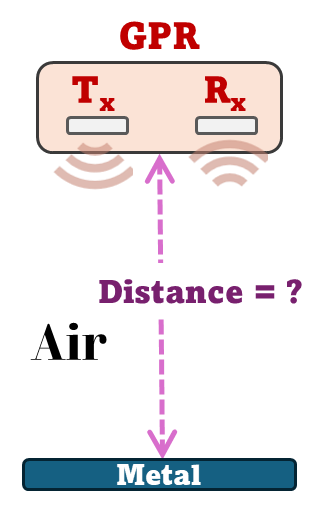

# Packages and Utility functions

#### All necessary packages and gprMax need to be installed to run the following codes

In [1]:
import numpy as np; 
from gprMax.utilities import detect_check_gpus; 
from gprMax.gprMax import api; 
import h5py; 
import matplotlib.pyplot as plt; 
import math
detect_check_gpus([1]);
import os; 
import torch
import time; 
from IPython.display import clear_output; 
os.getcwd(); 
from GPUtil import showUtilization as gpu_usage
from numba import cuda; 
import gc; 
import pycuda.driver; 
import random; 
import pandas as pd; 
from scipy.signal import hilbert
from bayes_opt import BayesianOptimization; 
import plotly.graph_objects as go; 
import pickle

def free_gpu_cache():
    gc.collect(); 
    torch.cuda.empty_cache(); 
    cuda.select_device(1); 
    cuda.close(); 
    cuda.select_device(1); 
    gpu_usage()
free_gpu_cache()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

| ID | GPU  | MEM |
-------------------
|  0 |  88% | 21% |
|  1 | 100% | 40% |


In [2]:
## Function to 
#   1. MATCH LENGTH of experimental and numerical signal, 
#   2. Perform HILBERT TRANSFORM to get amplitude envelope and
#   3. NORMALIZE both experimental and numerical A-scans

def signal_length_matching(smaller,longer):
    # Changing shape of the experimental signal
    original_vector = smaller
    new_size = longer.shape[0]                                          # Specify the desired new size
    original_indices = np.arange(original_vector.size)                  # Create an array of indices for the original vector
    new_indices = np.linspace(0, original_indices.max(), new_size)      # Create an array of indices for the new vector
    smaller_new = np.interp(new_indices, original_indices, original_vector) # Perform linear interpolation

    # Normalize and hilbert transform the signals
    longer      = np.abs(hilbert(longer));          smaller_new = np.abs(hilbert(smaller_new))              # HILBERT TRANSFORM    
    longer   = longer/(np.max(abs(longer)));        smaller_new  = smaller_new/(np.max(abs(smaller_new)))   # Normalize
    
    clear_output()
    return smaller_new, longer

# Distance Prediction

### A-scan from Experimental  (True distance = 0.645 m)

In [3]:
data = pd.read_csv('FILE__139.CSV')         # This file contains experimental A-scans for metal at true distance = 64.5 cm from GPR
A_exp = data.iloc[5:15].mean()[:];          # Taking mean of 10 A-scans
A_exp = A_exp - np.mean(A_exp)              # Subtracting mean amplitude

time= 8.51e-9                                   # Total time of experimental A-scan is 8.51 ns. 
t_exp = np.linspace(0, time, A_exp.shape[0])    # Forming the time vector

### A-scan from 2D FDTD simulation

In [4]:
tw = t_exp[-1];                             # Simulation time window, tw = expt time window

# Function to conduct simulation
def model_2D(p1,c1,p2,c2, dep, waveform, freq, bs, dd):
    b=0.02
    X=0.4; Y=1.1; dx=0.002; Z=dx; gpr_Y = dep+b+dd; freq = freq; Tx=X/2-0.09
    with open("PEC_Calib.in", "w") as f:
        f.write(f"#title: Soil_15cm + PEC \n#domain: {X} {Y} {Z}\n#dx_dy_dz: {dx} {dx} {dx}")
        f.write(f"\n#time_window: {tw} \n#material: {p1} {c1} 1 0 mat1 \n#material: {p2} {c2} 1 0 mat2")
        f.write(f"\n#waveform: {waveform} 2 {freq} my_wave")
        f.write(f"\n#hertzian_dipole: z {Tx} {gpr_Y} 0 my_wave\n#rx: {Tx+bs} {gpr_Y} 0")
        f.write(f"\n#box: 0 {b} 0 {X} {dep+b} {Z} mat1")        
        f.write(f"\n#box: 0 {dep+b} 0 {X} {dep+b+2*dd} {Z} mat2")        
        f.write(f"\n#box: 0 {b-.01} 0 {X} {b} {Z} pec")
        f.write(f"\n#geometry_view: 0 0 0 {X} {Y} {Z} {dx} {dx} {dx} PEC_Calib n\n")
        f.close()

    api("PEC_Calib.in", geometry_only=False, gpu=[0])
    hf2 = h5py.File("PEC_Calib.out", 'r', libver='latest', swmr=True)
    Ascan = hf2['rxs/rx1/Ez'][:]
    hf2.close()
    free_gpu_cache();clear_output()
    return Ascan            

### Depth prediction by Bayesian Optimization

In [5]:
# Bayesian Optimization
Opt_MaxGA=[]
for i in range(1):
    def mae_func(dep):
        sim = model_2D(p1=1.01,     # p1 = Permittivity of air
               c1=0,                # c1 = Conductivity of air
               p2=1.36,             # p2 = eps_g in paper
               c2=0.012,            # c2 = sigma_g in paper
               dep=dep,             # dep = depth or distance of metal from GPR-- kept as VARIABLE here to be optimized
               waveform="gaussian", # waveform type
               freq=1.44e9,         # freq = center frequency
               bs=0.062,            # bs = bistatic separation
               dd=0.02              # dd = d_g in paper
               ) 
        vector1,vector2 = signal_length_matching(A_exp,sim)
        
        vector2 = np.array(vector2)
        vector2 = vector2/(np.max(abs(vector2))) 
        result1 = -100*np.sqrt(np.sum((vector1 - vector2)**2))/(np.sqrt(np.sum(vector1**2)))
        
        return result1

    bounds = {'dep':(0.1,1.0)} 
    optimizer = BayesianOptimization(f=mae_func, 
                                     pbounds=bounds, 
                                     allow_duplicate_points=True)
    optimizer.maximize(init_points=20, n_iter=10)
    
    print("Optimization completed successfully."); 
    Opt_MaxGA.append((i + 1,optimizer.max))
    
for serial, result in Opt_MaxGA:
    print(f"Opt. {serial}: {result}")

| 30        | -9.349    | 0.6518    |
Optimization completed successfully.
Opt. 1: {'target': -9.349300663756356, 'params': {'dep': 0.6518732562021736}}


### Comparison of experimental and simulated scan with predicted distance

Predicted distance is = 0.6518732562021736 m


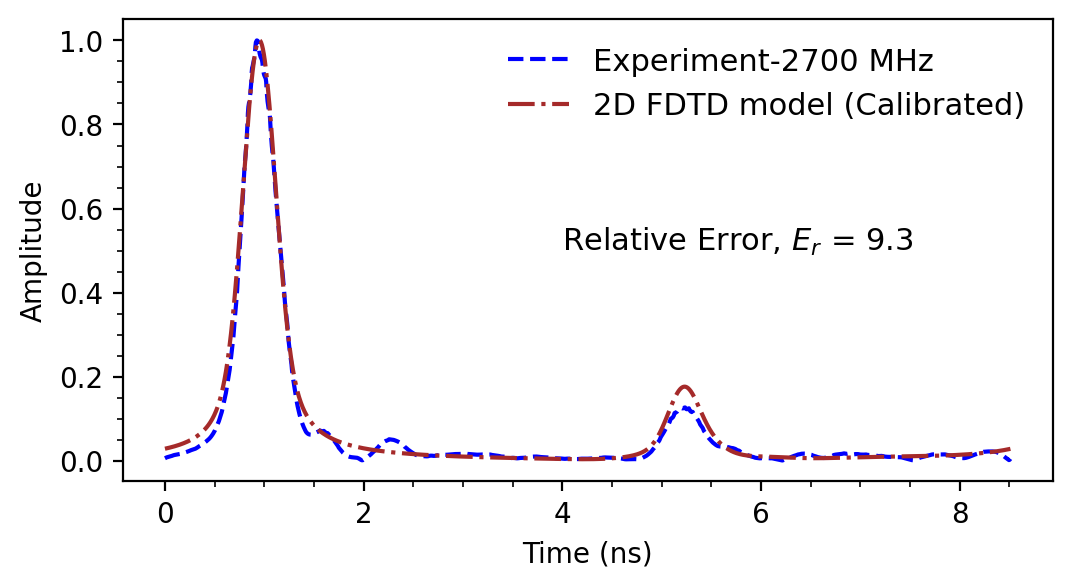

In [6]:
# Execute simulation with predicted distance
pred_dep = result['params']['dep']  # Predicted depth or distance


sim = model_2D(p1=1.01,             # p1 = Permittivity of air
               c1=0,                # c1 = Conductivity of air
               p2=1.36,             # p2 = eps_g
               c2=0.012,            # c2 = Permittivity of air
               dep=pred_dep,        # dep = depth or distance of metal from GPR, here predicted depth = 0.65 is used
               waveform="gaussian", # waveform type
               freq=1.44e9,         # freq = center frequency
               bs=0.062,            # bs = bistatic separation
               dd=0.02              # dd = d_g
               ) 


t_vec = np.linspace(0, tw, sim.shape[0])
a, b = signal_length_matching(A_exp,sim)

plt.figure(figsize=(6, 3), dpi=200)
plt.plot(t_vec*1e9, a, label='Experiment-2700 MHz', linestyle='--', color='blue');  
plt.plot(t_vec*1e9, b, label='2D FDTD model (Calibrated)', linestyle='-.', color='brown'); 
plt.xlabel('Time (ns)')   
plt.ylabel('Amplitude') 
plt.minorticks_on()
plt.legend(fontsize=11, loc='best', frameon=False);
re = 100*np.sqrt(np.sum((a - b)**2))/(np.sqrt(np.sum(a**2)))
plt.text(4, 0.5, f'Relative Error, $E_{{r}}$ = {re:.1f}', fontsize=11);

print('Predicted distance is =', pred_dep, 'm')